<h1><center>IST 597 Foundations of Deep Learning</center></h1>

---

<h2><center>Autoencoders</center><h2>
<h3><center>Neisarg Dave</center><h3>

In [1]:
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
%matplotlib inline
import warnings
from sklearn import manifold
device = torch.device("cuda:0")

seed = 1234 
random.seed(seed)
torch.manual_seed(seed)

In [2]:
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

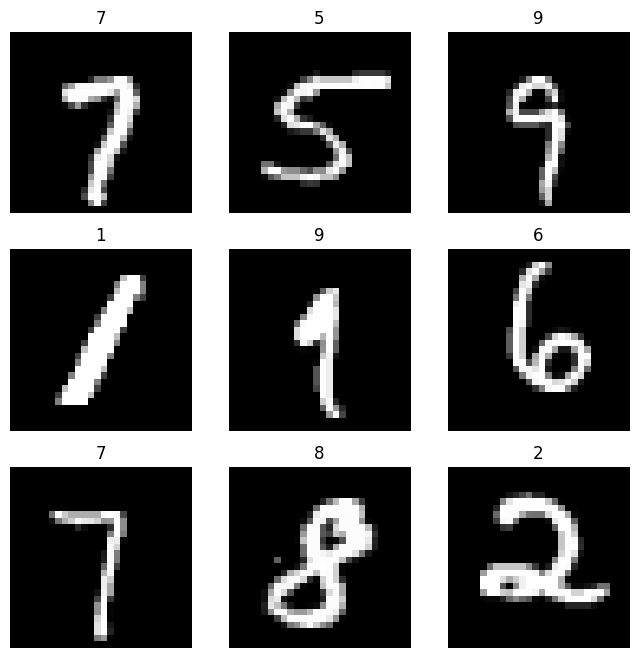

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
class Autoencoder(torch.nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = torch.nn.Sequential(
              torch.nn.Linear(784, 256),
              torch.nn.Sigmoid(),
              torch.nn.Linear(256, 128),
              torch.nn.Sigmoid())
    self.decoder = torch.nn.Sequential(
              torch.nn.Linear(128, 256),
              torch.nn.Sigmoid(),
              torch.nn.Linear(256, 784),
              torch.nn.Sigmoid())
  
  def forward(self, x):
    latent = self.encoder(x)
    out = self.decoder(latent)
    return out, latent

In [5]:
def live_plots(latent, labels, steps, loss, xlim, ylim):
    clear_output(wait=True)
    fig = plt.figure(figsize=(24, 12))

    ax1 = fig.add_subplot(1, 2, 1)
    
    ax1.set_xlim(0, xlim)
    ax1.set_ylim(0, ylim)
    x = [float(i) for i in steps]
    y = [float(i) for i in loss]
    
    if len(x) > 1:
        ax1.scatter(x,y, label='axis y', color='k') 
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, [x * m for x in x] + b)

    ax1.set_title("Loss Curve")
    ax1.grid(True)
    ax1.set_xlabel('# Iterations')
    ax1.set_ylabel('Loss')
    #plt.show();

    #figure = plt.figure(figsize=(16, 8))
    t_sne = manifold.TSNE(
    n_components=2,
    perplexity=60,
    init="random",
    n_iter=250,
    random_state=0,
    )
    latent = t_sne.fit_transform(latent)
    viridis = mpl.colormaps['viridis'].resampled(10)
    warnings.filterwarnings("ignore")
    ax = fig.add_subplot(1, 2, 2)
    for label in range(10):
      indices = (labels == label).nonzero().squeeze()
      vec = latent[indices]
      ax.scatter(vec[:, 0], vec[:, 1], c= viridis(label), label = label, alpha = 0.5)
    
    ax.legend()
    ax.grid(True)
    ax.set_title("latent space")

    plt.show()

In [6]:
model = Autoencoder().cuda()

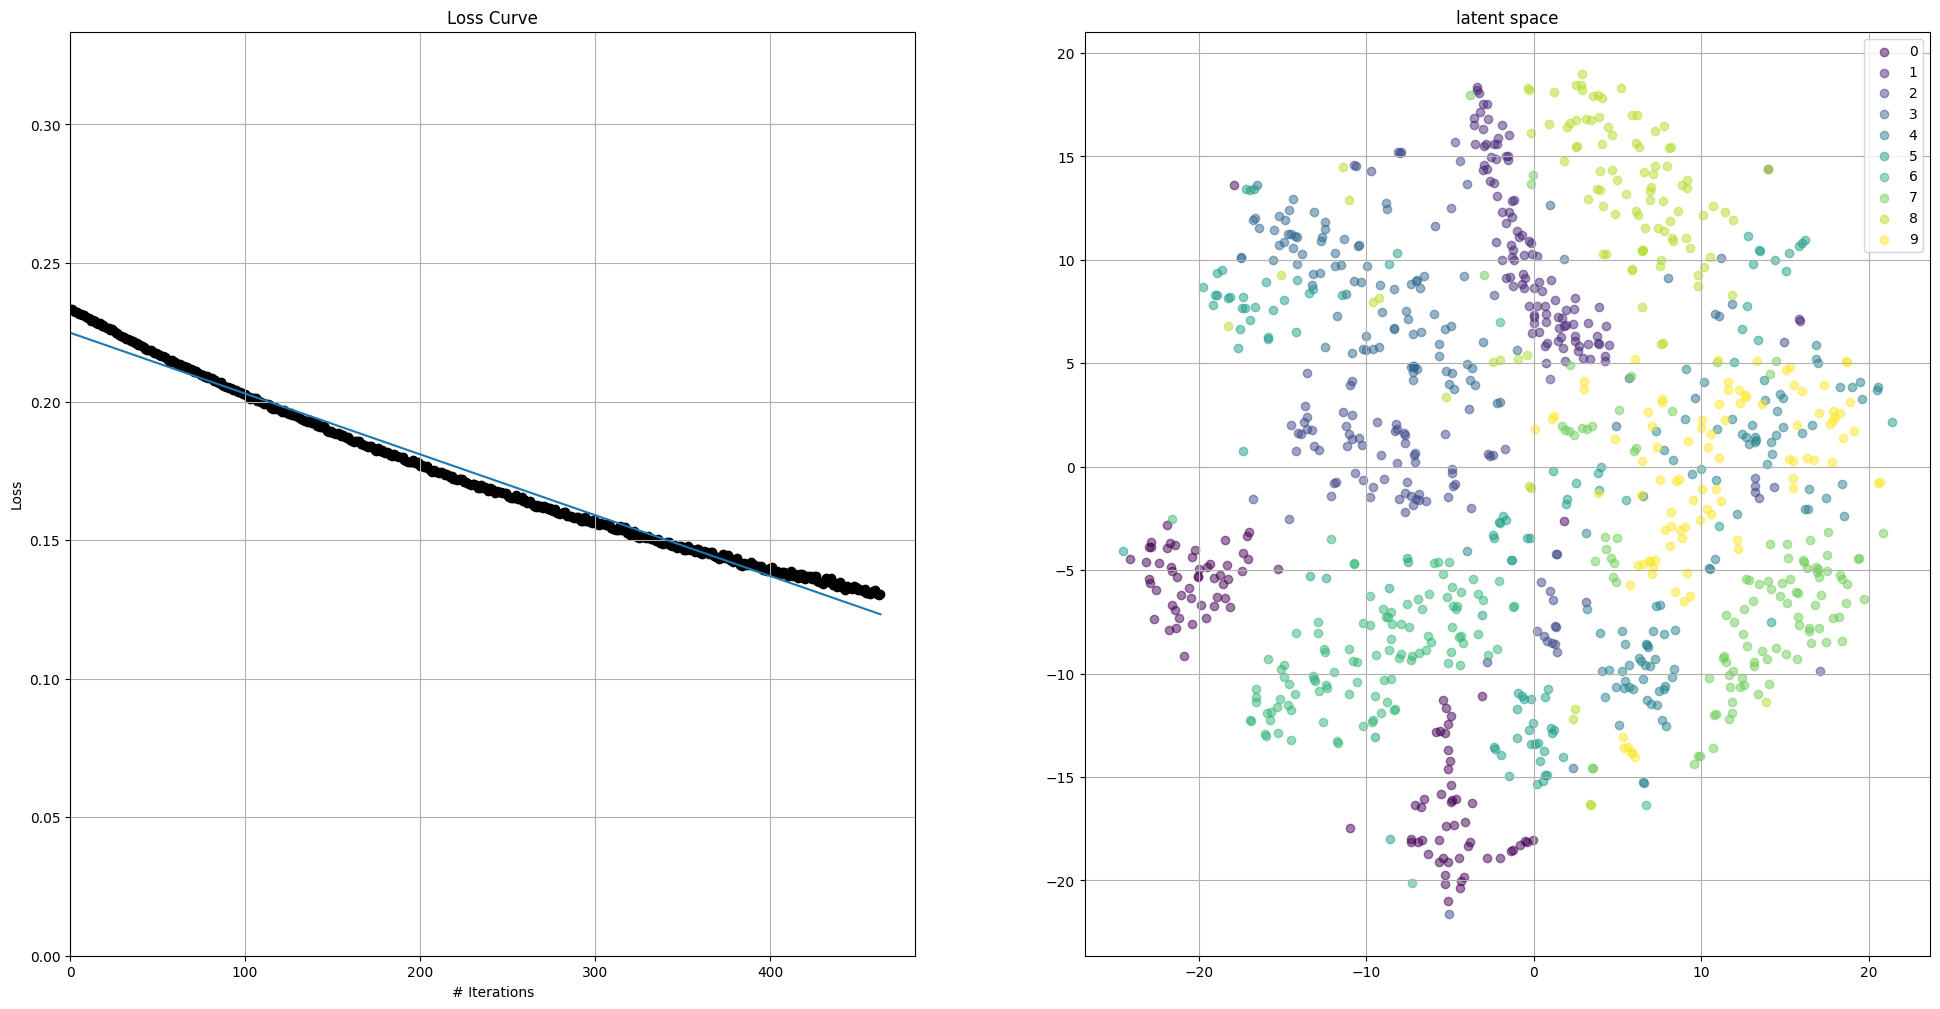

In [ ]:
from torch.utils.data.dataloader import DataLoader
train_data = DataLoader(train_dataset, batch_size = 1024)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()
nepochs = 50
loss_buffer = []
steps_buffer = []
for epoch in range(nepochs):
  for ii, batch_data in enumerate(train_data):
    # prepare data
    data, labels= batch_data
    data = data.reshape([-1, 784]).cuda()
    #labels = labels.cuda()
    
    # run model
    logits, latent = model(data)
    
    # calculate loss 
    loss = loss_fn(logits, data)

    # run optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print(epoch*len(train_data) + ii, loss.item())
    # plot loss and visualize weights
    loss_buffer.append(loss.detach().cpu())
    steps_buffer.append(epoch*len(train_data) + ii)
    if ii % 10 == 0:
      live_plots(latent.cpu().detach().numpy(), labels, 
                 steps_buffer, loss_buffer, 
                steps_buffer[-1]+20, max(loss_buffer) + 0.1 )


+ More Visualizations:
    + https://douglasduhaime.com/posts/visualizing-latent-spaces.html